# List 3

## Random graph

In [14]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import collections
from scipy.stats import binom
from scipy import stats
from scipy.optimize import curve_fit
import powerlaw
from scipy.special import comb

sns.set()


In [6]:
class Graph(nx.Graph):
    
    def random_graph(self, n, p):
        eges_nr = np.sum([i for i in range(n)])
        edges = np.array([[i, j] for i in range(n-1) for j in range(i+1,n) if np.random.uniform() < p ])
        self.add_nodes_from(range(n))
        self.add_edges_from(edges)
        return self

    def degree_sequence(self) -> list:
        degree_list = [d for n, d in self.degree()]
        return sorted(degree_list, reverse=True)


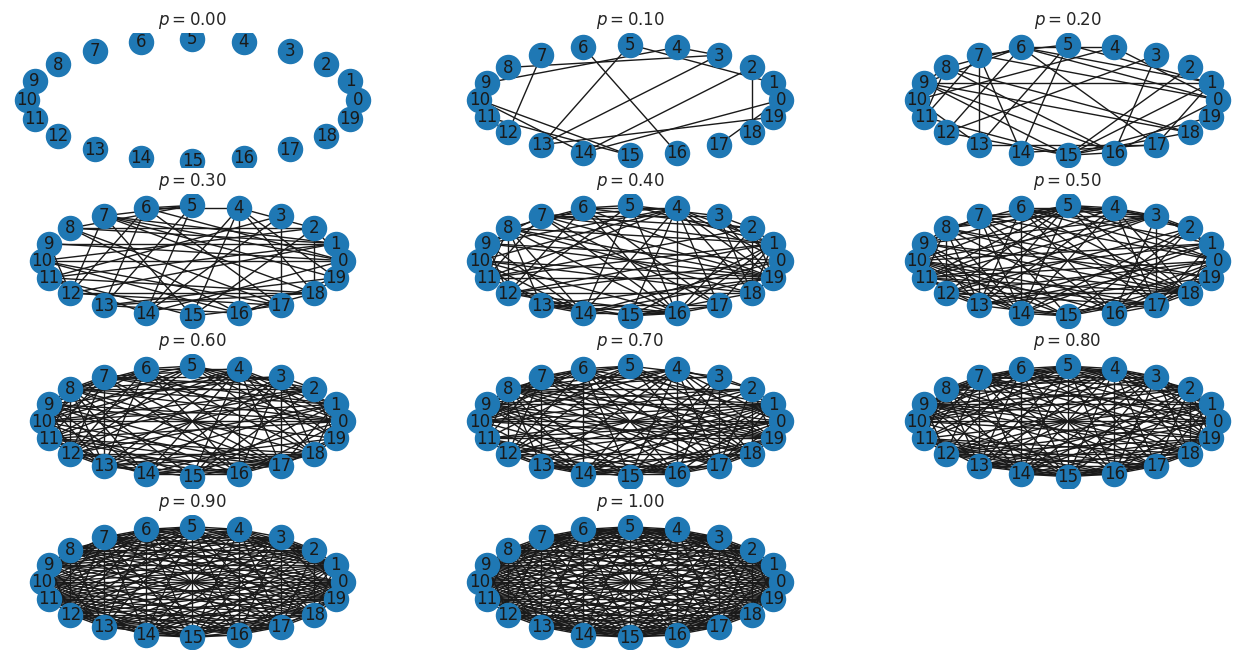

In [7]:
bvals = np.linspace(0,1,11)
N = 20
plt.figure(figsize=(16,8))
for m, b in enumerate(bvals):
    plt.subplot(4,3,m+1)
    g1 = Graph().random_graph(N, b)
    plt.title(r"$p = %.2f$"%b)
    nx.draw_circular(g1, with_labels = True)

In [23]:
n = 4000
p = 0.1
g1 = Graph().random_graph(n, p)
g1.degree_sequence()
degree_sequence = g1.degree_sequence()
xs = np.arange(min(degree_sequence), max(degree_sequence),1)
# plt.plot(xs, binom(n-1,p).pmf(xs), label = "$f_{B(%d,%a)}(x)$" %(n-1,p))


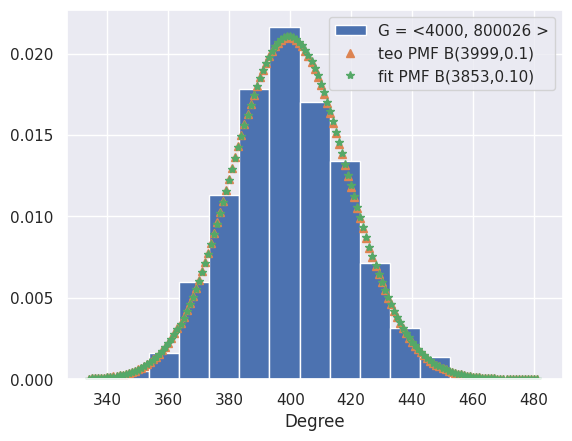

In [63]:
plt.hist(degree_sequence, density= True, bins = 15, label = f"G = <{len(g1.nodes)}, {len(g1.edges)} >")
dist = stats.binom   
res = stats.fit(dist, degree_sequence, [[3500,4500], [0,1]])
fit_n,fit_p = res.params[0],res.params[1]
plt.plot(xs, binom(n-1,p).pmf(xs), "^" , label = f"teo PMF B({n-1},{p})")
plt.plot(xs, binom(fit_n, fit_p).pmf(xs), "*", label = f"fit PMF B(%.d,%.2f)"%(fit_n, fit_p))
plt.legend()
plt.xlabel("Degree")
plt.show()

In [64]:
print(f"""
nodes = {len(g1.nodes)},
edges = {len(g1.edges)},
mean degre = {np.mean(degree_sequence)},
VAR degre = {np.var(degree_sequence)}""")


nodes = 4000,
edges = 800026,
mean degre = 400.013,
VAR degre = 359.306831


## Watts-Strogatz model

In [7]:
class Graph(nx.Graph):
    
    def random_graph(self, n, p):
        eges_nr = np.sum([i for i in range(n)])
        edges = np.array([[i, j] for i in range(n-1) for j in range(i+1,n) if np.random.uniform() < p ])
        # all_edges = np.array([[i, j] for i in range(n-1) for j in range(i+1,n)])
        # taked_edes = np.random.uniform(size=eges_nr)<p
        # edges_to_add = all_edges[taked_edes]
        self.add_nodes_from(range(n))
        # self.add_edges_from(edges_to_add)
        self.add_edges_from(edges)
        return self
    
    def Watts_Strogatz_model(self, n , k, p):
        """Returns a Watts–Strogatz small-world graph.

        Parameters
        ----------
        n : int
            The number of nodes
        k : int
            Each node is joined with its `k` nearest neighbors in a ring
            topology.
        p : float
            The probability of rewiring each edge
        """
        if k>n:
            raise ValueError(f"The parameter 'k' = {k} is greater than parametr 'n' = {n}")
        elif k == n:
            return nx.complete_graph(n)
        # g = nx.Graph()
        self.add_nodes_from(range(n))
        
        nodes = self.nodes
        for i in range(n):
            for j in range(1, k // 2 + 1):
                self.add_edge(i, (i+j)%n)
                
        for node in nodes:
            for neighbour in range(1, k // 2 + 1):
                if np.random.uniform() < p:
                    random_note = np.random.choice(nodes)
                    while node == random_note or self.has_edge(node, random_note):
                        random_note = np.random.choice(nodes)
                    else:
                        self.remove_edge(node, (node + neighbour)%n)
                        self.add_edge(node, random_note)
                else:
                    pass
        return self
    
    def degree_sequence(self) -> list:
        degree_list = [d for n, d in self.degree()]
        return sorted(degree_list, reverse=True)


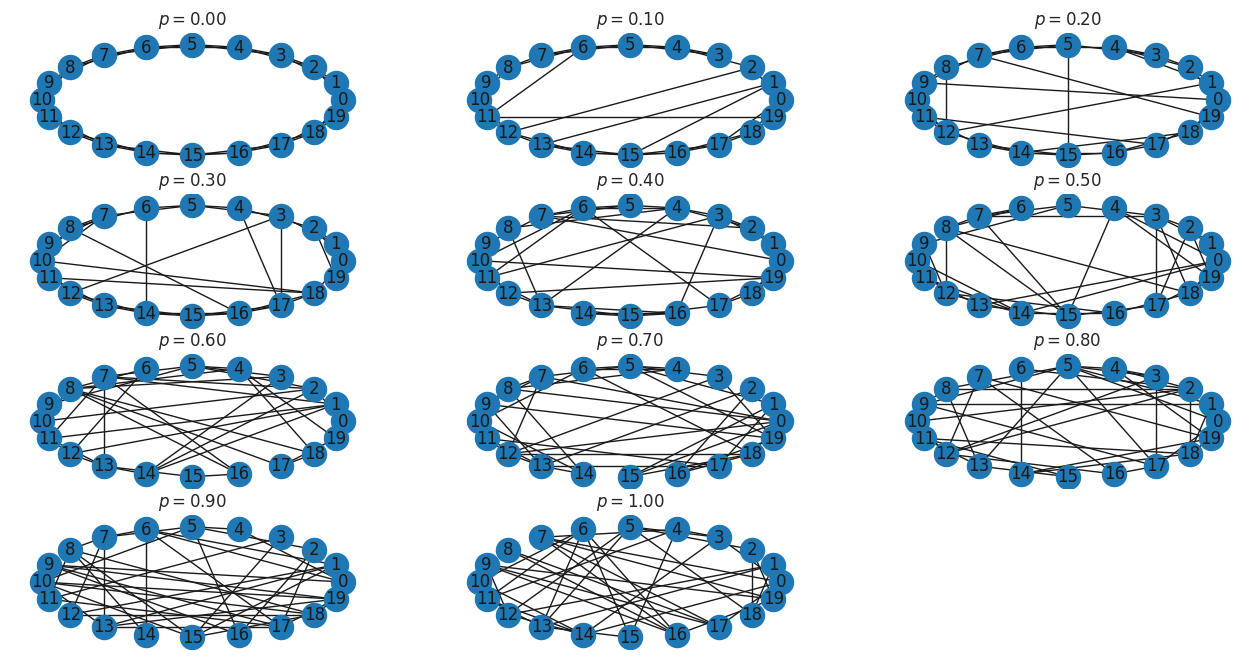

In [73]:
bvals = np.linspace(0,1,11)
n = 20
K = 4
plt.figure(figsize=(16,8))
for m, b in enumerate(bvals):
    plt.subplot(4,3,m+1)
    g2 = Graph().Watts_Strogatz_model(n, K, b)
    plt.title(r"$p = %.2f$"%b)
    nx.draw_circular(g2, with_labels = True)

In [49]:
def _density(k, K, p):
    pk = sum([comb(K/2, n )*(1-p)**n*p**(K/2-n)*(p*K/2)**(k-n-K/2)/np.math.factorial(int(k-n-K/2))*np.math.exp(-K/2*p) for n in range(int(min(k - K/2, K/2)+1)) ])
    return pk

def density(ks, K, p):
    return [_density(k, K, p ) for k in ks]


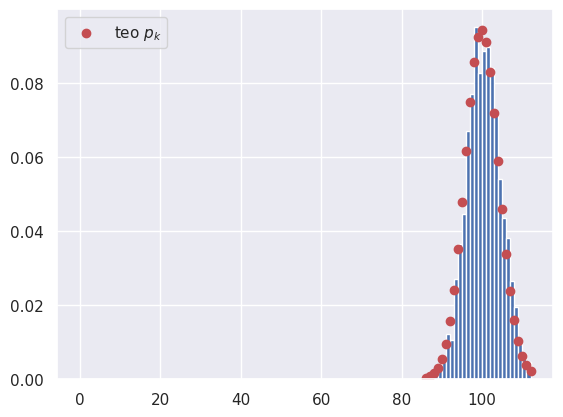

In [67]:
n = 2000
p = 0.2
K = 100
g2 = Graph().Watts_Strogatz_model(n, K, p)


degree_sequence = g2.degree_sequence()
xs = np.arange(min(degree_sequence), max(degree_sequence),1)
simulation = plt.hist(degree_sequence, density= True, bins=range(max(degree_sequence)))
plt.scatter(xs, density(xs, K, p), c= "r", label = "teo $p_k$")
plt.legend()

plt.show()

(array([101.        ,   0.22253976]),
 array([[ 0.00053503, -0.00021629],
        [-0.00021629,  0.00027876]]))

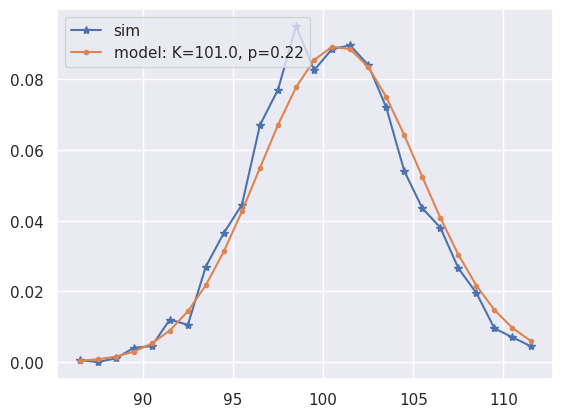

In [73]:
xdata = [0.5 * (simulation[1][i] + simulation[1][i+1]) for i in range(len(simulation[0]))]
ydata = simulation[0]
mean_dg = np.mean(degree_sequence)
std_dg = np.std(degree_sequence)

xdata = xdata[min(degree_sequence):max(degree_sequence)]
ydata = ydata[min(degree_sequence):max(degree_sequence)]

popt, pcov = curve_fit(density, xdata, ydata, p0 = [mean_dg, 0.5],bounds= [[mean_dg - std_dg, 0],[mean_dg + std_dg, 1]])
# popt[0] = int(popt[0])
plt.plot(xdata, ydata, '*-', label='sim')
popt[0] = int(popt[0] + 0.5)
plt.plot(xdata, density(xdata, popt[0], popt[1]), '.-', label=f'model: K=%a, p=%.02f'%(popt[0], popt[1]) )
plt.legend()
popt, pcov

In [74]:
print(f"""
nodes = {len(g2.nodes)},
edges = {len(g2.edges)},
mean degre = {np.mean(degree_sequence)},
VAR degre = {np.var(degree_sequence)}""")


nodes = 2000,
edges = 100000,
mean degre = 100.0,
VAR degre = 18.027


## Barabasi-Albert model

In [77]:
class Graph(nx.Graph):
    
    def random_graph(self, n, p):
        eges_nr = np.sum([i for i in range(n)])
        edges = np.array([[i, j] for i in range(n-1) for j in range(i+1,n) if np.random.uniform() < p ])
        # all_edges = np.array([[i, j] for i in range(n-1) for j in range(i+1,n)])
        # taked_edes = np.random.uniform(size=eges_nr)<p
        # edges_to_add = all_edges[taked_edes]
        self.add_nodes_from(range(n))
        # self.add_edges_from(edges_to_add)
        self.add_edges_from(edges)
        return self
    
    def Watts_Strogatz_model(self, n , k, p):
        """Returns a Watts–Strogatz small-world graph.

        Parameters
        ----------
        n : int
            The number of nodes
        k : int
            Each node is joined with its `k` nearest neighbors in a ring
            topology.
        p : float
            The probability of rewiring each edge
        """
        if k>n:
            raise ValueError(f"The parameter 'k' = {k} is greater than parametr 'n' = {n}")
        elif k == n:
            return nx.complete_graph(n)
        # g = nx.Graph()
        self.add_nodes_from(range(n))
        
        nodes = self.nodes
        for i in range(n):
            for j in range(1, k // 2 + 1):
                self.add_edge(i, (i+j)%n)
                
        for node in nodes:
            for neighbour in range(1, k // 2 + 1):
                if np.random.uniform() < p:
                    random_note = np.random.choice(nodes)
                    while node == random_note or self.has_edge(node, random_note):
                        random_note = np.random.choice(nodes)
                    else:
                        self.remove_edge(node, (node + neighbour)%n)
                        self.add_edge(node, random_note)
                else:
                    pass
        return self

    def barabasi_albert_model(self, m0, n, iterations, inicial_praph = None):
        if inicial_praph:
            g = inicial_praph
        else:
            g = nx.complete_graph(m0)
        degrees = {note:degre for note,degre in g.degree() }
        for node in range(m0, m0 + iterations):
            values = np.array(list(degrees.values()))
            nodes_to_conect = np.random.choice(list(degrees.keys()), size = n, replace=False, p = values/sum(values))
            degrees[node] = n
            for node_to_conect in nodes_to_conect:
                degrees[node_to_conect] += 1
            g.add_edges_from([[node, i] for i in nodes_to_conect ])
        return g
        
    def degree_sequence(self) -> list:
        degree_list = [d for n, d in self.degree()]
        return sorted(degree_list, reverse=True)


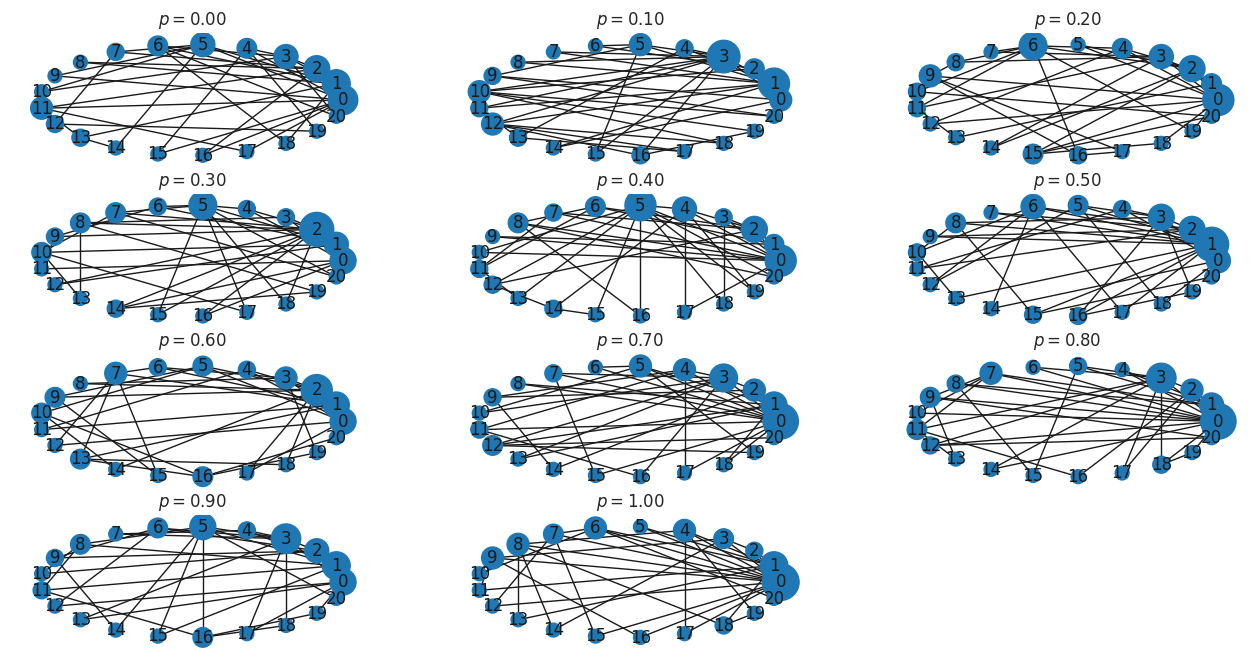

In [78]:
bvals = np.linspace(0,1,11)
m0 = 3
n = 2
iterations  = 18
plt.figure(figsize=(16,8))
for m, b in enumerate(bvals):
    plt.subplot(4,3,m+1)
    g3 = Graph().barabasi_albert_model(m0, n, iterations = iterations)
    plt.title(r"$p = %.2f$"%b)
    # nx.draw_circular(g1, with_labels = True)
    nx.draw_circular(g3, with_labels = True, node_size=[v * 50 for v in dict(g3.degree()).values()])

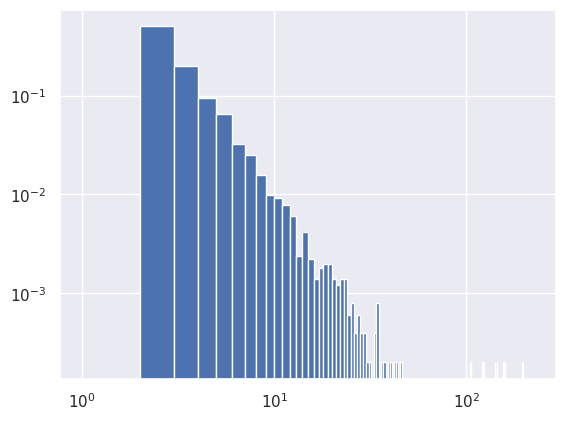

In [78]:
m0 = 10
n = 2
iterations  = 5000
g3 = Graph().barabasi_albert_model(m0, n, iterations = iterations)


degree_sequence = sorted([d for n, d in g3.degree()], reverse=True)  # degree sequence
n, bins, patches = plt.hist(degree_sequence, density= True, bins=range(max(degree_sequence)))
plt.yscale("log")
plt.xscale("log")
plt.show()

/tmp/ipykernel_29125/1841192100.py:8: RuntimeWarning: divide by zero encountered in log
  ln_n_tail = np.log(n_tail)


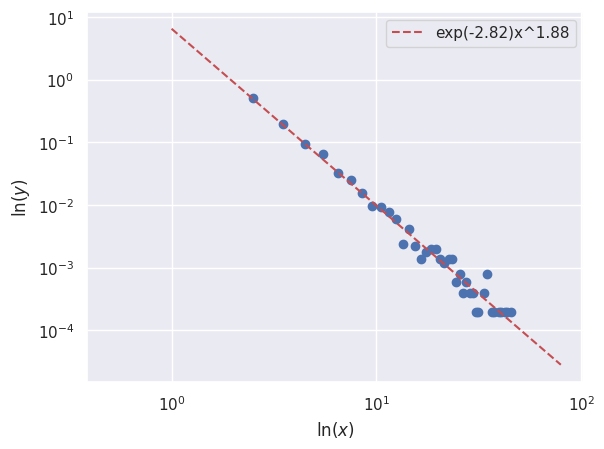

In [81]:
bins_mean = [0.5 * (bins[i] + bins[i+1]) for i in range(len(n))]
tail = 80
bins_mean_tail = bins_mean[:tail]
n_tail = n[:tail]

plt.scatter(bins_mean_tail, n_tail)
ln_bins_mean_tail = np.log(bins_mean_tail)
ln_n_tail = np.log(n_tail)
idx = np.isfinite(ln_bins_mean_tail) & np.isfinite( ln_n_tail )

a,b = np.polyfit(ln_bins_mean_tail[idx], ln_n_tail[idx], 1)
xs = np.linspace(1,max(bins_mean_tail),100)
ys = np.exp(b)*xs**a
plt.plot(xs, ys, "r--" , label = "exp(%.2f)x^%.2f"%(a,b))

plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.ylabel("$\\ln(y)$")
plt.xlabel("$\\ln(x)$")
plt.show()


In [82]:
print(f"""
nodes = {len(g3.nodes)},
edges = {len(g3.edges)},
mean degre = {np.mean(degree_sequence)},
VAR degre = {np.var(degree_sequence)}""")


nodes = 5010,
edges = 10045,
mean degre = 4.009980039920159,
VAR degre = 58.74600818323435
